# **Modeling and Evaluation Notebook**

## Objectives

- Answer Business Requirement 2: Develop a Machine Learning model to classify cherry leaves as Healthy or Infected, enabling the prediction of powdery mildew presence.

## Inputs

Dataset
- inputs/mildew_dataset/cherry-leaves/train
- inputs/mildew_dataset/cherry-leaves/validation
- inputs/mildew_dataset/cherry-leaves/test

Precomputed Features (from Data Visualization Notebook)
- Image Shape Standardization → 128x128x3 for consistency across models.
- Class Distribution Analysis → Ensures balanced dataset splits.
- Pixel Intensity Distribution → Confirms brightness variations relevant for classification.

## Outputs

### Data Processing & Visualization
- **Dataset Distribution Plot** → Confirms balanced data split across training, validation, and test sets.  
- **Data Augmentation Visualization** → Showcases applied transformations (rotation, flipping, zooming).  

### Model Training & Evaluation
- **Baseline CNN Models (Sigmoid & Softmax)** → Initial experiments to establish a benchmark.  
- **MobileNetV2 Fine-Tuning** → Explored optimized architectures with different hyperparameters.  
- **Best Model Selection** → Chose the most balanced model based on test accuracy, generalization, and robustness.  
- **Saved Trained Model** → Final MobileNetV2 model stored for deployment.  

### Model Performance & Explainability
- **Learning Curves** → Visualizes loss and accuracy trends over epochs.  
- **Histograms** → Displays predicted probability distributions.  
- **Overfitting & Generalization Check** → Assesses potential overfitting using accuracy and loss gaps.  
- **Confusion Matrices** → Shows classification performance for train, validation, and test sets.  
- **Classification Reports** → Provides precision, recall, and F1-score analysis.  
- **ROC Curves** → Evaluates model performance using Receiver Operating Characteristic analysis.  
- **Business Goal Validation** → Confirms if the model meets the required accuracy threshold.  

## Additional Comments

- **Business Impact:** Enables early detection of powdery mildew, reducing manual inspection and improving monitoring.  
- **Data-Driven Improvements:** Model refinements were based on data insights, ensuring balanced class distribution.  
- **Deployment:** The optimized model is ready for Streamlit integration for real-world use.  



---

# Set Data Directory

---

## Import Necessary Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

You set a new current directory


#### Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detector'

## Set Input Directories

In [5]:
# Set input directories
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

## Set Output Directory

In [6]:
version = "v1"
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['Healthy', 'Infected']


## Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(128, 128, 3)

---

## Number of Images in Train, Test and Validation Data

In [9]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset folders
folders = ['train', 'validation', 'test']

# Loop through each dataset split and count images
for folder in folders:
    for label in labels:
        path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(path)) if os.path.exists(path) else 0  
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)
        print(f" {folder}/{label}: {num_images} images")

# Convert dictionary to DataFrame
df_freq = pd.DataFrame(data)

 train/Healthy: 1472 images
 train/Infected: 1472 images
 validation/Healthy: 210 images
 validation/Infected: 210 images
 test/Healthy: 422 images
 test/Infected: 422 images


### Bar Chart - Image Distribution

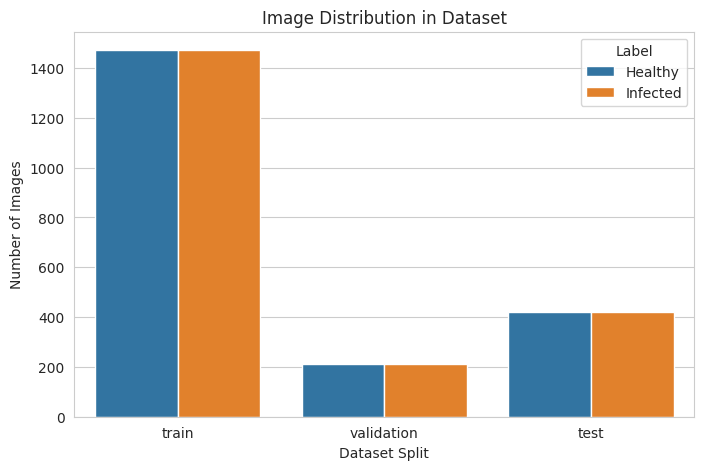

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Dataset")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Implement Data Augmentation

---

### ImageDataGenerator

In [11]:
# Import TensorFlow/Keras ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-05 16:00:58.264936: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 16:00:58.294721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment Training, Validation, and Test Sets

- Initialize ImageDataGenerator for Data Augmentation

In [12]:
# Define Augmentation for Training Set
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

- Augment Training Image Dataset

In [13]:
batch_size = 16  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Validation Image Dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

- Augment Test Image Dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'Healthy': 0, 'Infected': 1}

---

## Visualization of Augmented Images

### Plot Augmented Training Image

(16, 128, 128, 3)


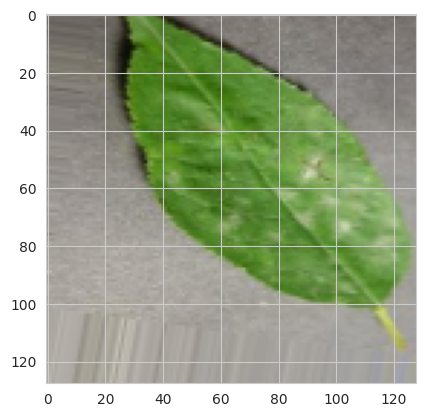

(16, 128, 128, 3)


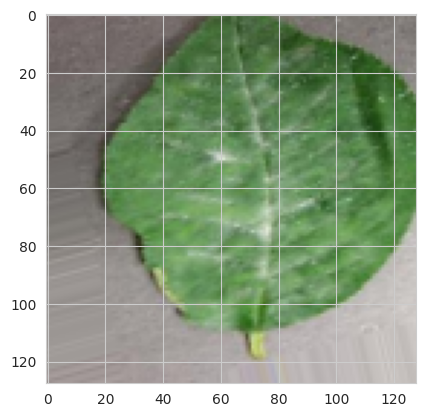

(16, 128, 128, 3)


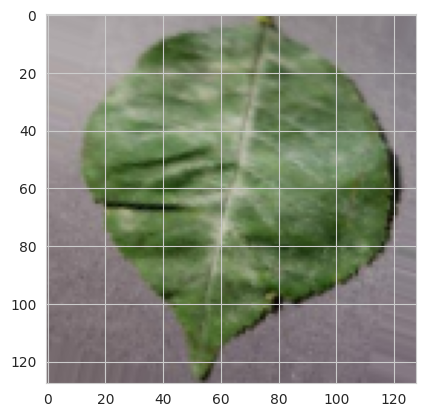

In [16]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Plot Augmented Validation and Test Images

(16, 128, 128, 3)


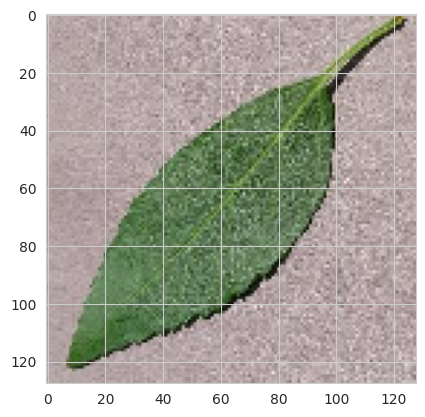

(16, 128, 128, 3)


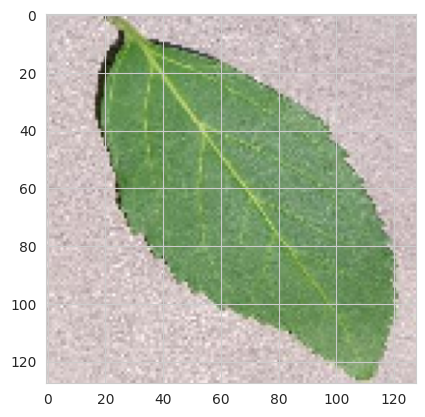

(16, 128, 128, 3)


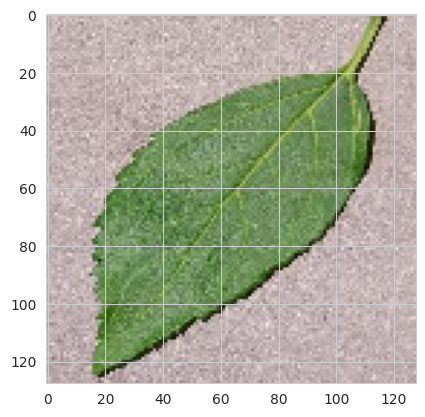

In [17]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(16, 128, 128, 3)


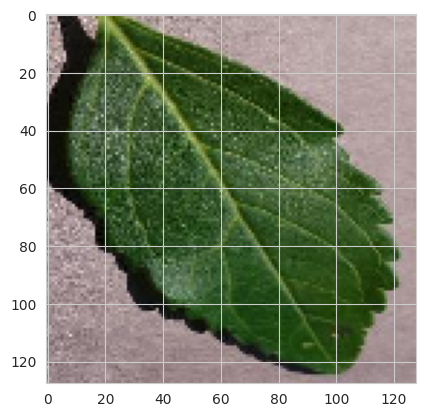

(16, 128, 128, 3)


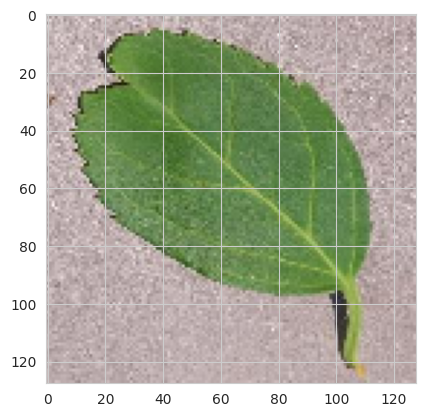

(16, 128, 128, 3)


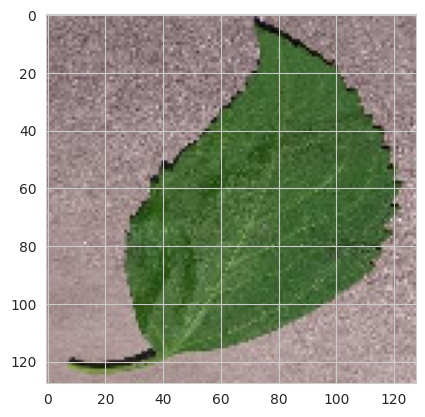

In [18]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

### Compare Multiple Augmented Images in a Grid

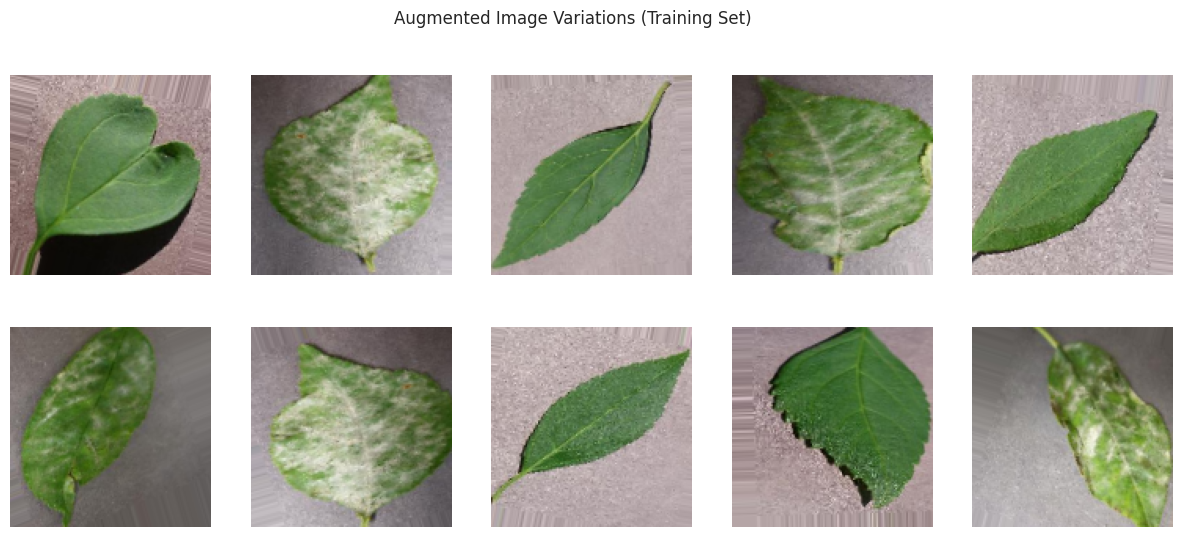

In [20]:
def plot_augmented_images_grid(data_generator, num_images=10):
    """Displays a grid of augmented images to visualize transformation effects."""
    img_batch, label_batch = next(data_generator)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    
    for i in range(num_images):
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(img_batch[i])
        ax.axis("off")

    plt.suptitle("Augmented Image Variations (Training Set)")
    plt.show()

# Display the augmented image grid
plot_augmented_images_grid(train_set)

---

# Model Creation

---

### Import Libraries

In [21]:
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

## MobileNetV2

MobileNetV2 was chosen for its efficiency, speed, and strong feature extraction while maintaining high accuracy with fewer parameters. Its lightweight architecture makes it ideal for deployment in resource-constrained environments. Details are provided in the README.

In [22]:
# Define best hyperparameters from tuning
l2_lambda = 0.002  # Best L2 regularization strength
best_units = 128  # Best number of dense units
best_dropout = 0.4  # Best dropout rate
best_lr = 0.0001  # Best learning rate

# Create model
model_mobilenet = Sequential(
    [
        MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3)),
        GlobalAveragePooling2D(),
        Dense(best_units, activation="relu", kernel_regularizer=l2(l2_lambda)),
        Dropout(best_dropout),
        Dense(2, activation="softmax"),
    ]
)

model_mobilenet.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


### Model Summary

In [23]:
# Print Model Summary
model_mobilenet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

---

## Model Training

### Early Stopping Implementation

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True
)

# Reduce Learning Rate when `val_loss` stagnates
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6
)

# Save the best model
m_checkpoint = ModelCheckpoint(
    filepath="outputs/v1/mobilenetv2.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)


### Fit Model for Training

In [25]:
# Train model
history = model_mobilenet.fit(
    train_set,
    epochs=7,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop, lr_scheduler, m_checkpoint],
    verbose=1,
)

Epoch 1/7


/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9225 - loss: 0.6389

184/184 ━━━━━━━━━━━━━━━━━━━━ 110s 474ms/step - accuracy: 0.9227 - loss: 0.6382 - val_accuracy: 0.8881 - val_loss: 0.7862 - learning_rate: 1.0000e-04
Epoch 2/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 84s 457ms/step - accuracy: 0.9912 - loss: 0.4364 - val_accuracy: 0.8000 - val_loss: 1.1167 - learning_rate: 1.0000e-04
Epoch 3/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9990 - loss: 0.3770

184/184 ━━━━━━━━━━━━━━━━━━━━ 144s 471ms/step - accuracy: 0.9990 - loss: 0.3770 - val_accuracy: 0.9357 - val_loss: 0.5315 - learning_rate: 1.0000e-04
Epoch 4/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9988 - loss: 0.3390

184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 457ms/step - accuracy: 0.9988 - loss: 0.3390 - val_accuracy: 0.9952 - val_loss: 0.3197 - learning_rate: 1.0000e-04
Epoch 5/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 87s 471ms/step - accuracy: 0.9997 - loss: 0.3003 - val_accuracy: 0.9929 - val_loss: 0.3040 - learning_rate: 1.0000e-04
Epoch 6/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 457ms/step - accuracy: 0.9995 - loss: 0.2655 - val_accuracy: 0.9952 - val_loss: 0.2677 - learning_rate: 1.0000e-04
Epoch 7/7
184/184 ━━━━━━━━━━━━━━━━━━━━ 84s 456ms/step - accuracy: 0.9987 - loss: 0.2424 - val_accuracy: 0.9905 - val_loss: 0.2701 - learning_rate: 1.0000e-04


### Save Training History

In [27]:
import pandas as pd
import os

# Ensure directory exists
os.makedirs("outputs/v1", exist_ok=True)

# Save training history
df_history_mobilenet = pd.DataFrame(history.history)
df_history_mobilenet.to_csv("outputs/v1/history_mobilenet.csv", index=False)


### Load Saved Best Model

In [28]:
from tensorflow.keras.models import load_model

# Load trained model
model_mobilenet = load_model("outputs/v1/mobilenetv2.h5")

---

# Model Performance and Evaluation

---

### Import Packages

In [29]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

### Load Saved Model

In [33]:
from keras.models import load_model

# Load the model
model = load_model("outputs/v1/mobilenetv2.h5")


## Model Evaluation

In [34]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ", evaluation[0])

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.9991 - loss: 0.3081
Model accuracy: 99.53%
Model Loss:  0.3180731534957886


## Set Accuracy Variables

In [35]:
# Correctly obtain true labels
y_true = test_set.labels

# Obtain model predictions
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step


## Load Training History

In [2]:
import pandas as pd

file_path = "/workspaces/mildew-detector/outputs/v1/history_mobilenet.csv"
df_history_mobilenet = pd.read_csv(file_path)

print("Training history loaded successfully!")

Training history loaded successfully!


## Learning Curves

In [ ]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt

output_dir = "outputs/v1"

# Convert df_history_mobilenet to long format for Plotly
df_long = df_history_mobilenet.reset_index().melt(
    id_vars=["index"],
    value_vars=["loss", "val_loss", "accuracy", "val_accuracy"],
    var_name="Metric",
    value_name="Value",
)
df_long.rename(columns={"index": "Epoch"}, inplace=True)

# Split into two DataFrames: one for loss, one for accuracy
df_loss = df_long[df_long["Metric"].isin(["loss", "val_loss"])]
df_acc = df_long[df_long["Metric"].isin(["accuracy", "val_accuracy"])]

# Interactive Loss Curve
fig_loss = px.line(
    df_loss,
    x="Epoch",
    y="Value",
    color="Metric",
    markers=True,
    title="Loss - MobileNetV2",
    labels={"Value": "Loss", "Epoch": "Epoch"},
    template="plotly_white",
)

# Interactive Accuracy Curve
fig_acc = px.line(
    df_acc,
    x="Epoch",
    y="Value",
    color="Metric",
    markers=True,
    title="Accuracy - MobileNetV2",
    labels={"Value": "Accuracy", "Epoch": "Epoch"},
    template="plotly_white",
)

# Save the figures as static PNGs
fig_loss.write_image(f"{output_dir}/model_training_losses.png", scale=2)
fig_acc.write_image(f"{output_dir}/model_training_acc.png", scale=2)

# Show interactive plots
fig_loss.show()
fig_acc.show()

- **Accuracy:** Training accuracy quickly reaches **~1.0**, while validation accuracy steadily improves with a small gap (~1%).  
- **Loss:** Both training and validation loss decrease consistently, showing stable learning with **no major overfitting**.  

## Histograms

The histogram below shows the overall distribution of model confidence scores for predictions on the test set. To explore individual image confidence levels and analyze misclassifications, please refer to the interactive version in the Streamlit dashboard.

In [ ]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

output_dir = "outputs/v1"

# Get predicted probabilities
y_pred_probs = model_mobilenet.predict(validation_set)

# Create DataFrame for Plotly
df_probs = pd.DataFrame({"Healthy": y_pred_probs[:, 0], "Infected": y_pred_probs[:, 1]})

# Create histogram traces for both classes
fig = go.Figure()

fig.add_trace(
    go.Histogram(
        x=df_probs["Healthy"],
        nbinsx=20,
        opacity=0.6,
        name="Healthy",
        marker_color="green",
    )
)

fig.add_trace(
    go.Histogram(
        x=df_probs["Infected"],
        nbinsx=20,
        opacity=0.6,
        name="Infected",
        marker_color="blue",
    )
)

# Add threshold line at 0.5
fig.add_trace(
    go.Scatter(
        x=[0.5, 0.5],
        y=[
            0,
            max(np.histogram(y_pred_probs[:, 1], bins=20)[0]),
        ],  # Adjust y-axis dynamically
        mode="lines",
        name="Threshold = 0.5",
        line=dict(color="red", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title="Prediction Probability Histogram",
    xaxis_title="Prediction Probability",
    yaxis_title="Count",
    barmode="overlay",
    template="plotly_white",
)

# Save the figure as a static PNG
fig.write_image(f"{output_dir}/histogram_test.png", scale=2)

# Show the interactive plot
fig.show()

The histogram shows a clear separation between **healthy** and **infected** predictions, with most probabilities concentrated near 0 and 1. The decision threshold at **0.5** is well-placed, ensuring confident classifications. Minimal overlap suggests strong model confidence in distinguishing between classes.

## Overfitting & Generalization Check

In [ ]:
# Extract the last recorded training & validation metrics
train_acc = history_mobilenet.history["accuracy"][-1]
val_acc = history_mobilenet.history["val_accuracy"][-1]
train_loss = history_mobilenet.history["loss"][-1]
val_loss = history_mobilenet.history["val_loss"][-1]

# Compute Generalization Gap
accuracy_gap = train_acc - val_acc
loss_gap = val_loss - train_loss

print("\n### Generalization & Overfitting Check ###")
print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Accuracy Gap: {accuracy_gap:.4f}")

print(f"Final Train Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Loss Gap: {loss_gap:.4f}")

# Overfitting Analysis
if accuracy_gap > 0.05:
    print(
        "\nOverfitting detected: The model performs significantly better on training data than validation data."
    )

if loss_gap > 0.05:
    print(
        "\nOverfitting detected: Validation loss is significantly higher than training loss."
    )

if accuracy_gap < 0.05 and loss_gap < 0.05:
    print("\nNo significant overfitting detected. Model generalizes well.")

## Confusion Matrix

In [ ]:
import numpy as np
import os
import pandas as pd
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

output_dir = "outputs/v1"

# Get Class Labels
label_map = list(test_set.class_indices.keys())

# Evaluate Model on Train and Test Sets
y_true_train = train_set.classes
y_pred_train = np.argmax(model_mobilenet.predict(train_set), axis=1)

y_true_test = test_set.classes
y_pred_test = np.argmax(model_mobilenet.predict(test_set), axis=1)

# Generate Confusion Matrices
cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Convert confusion matrices to DataFrames
df_cm_train = pd.DataFrame(cm_train, index=label_map, columns=label_map)
df_cm_test = pd.DataFrame(cm_test, index=label_map, columns=label_map)


# Function to create interactive Confusion Matrix
def create_confusion_matrix_figure(conf_matrix, title):
    fig = ff.create_annotated_heatmap(
        z=conf_matrix.values,
        x=conf_matrix.columns.tolist(),
        y=conf_matrix.index.tolist(),
        colorscale="Blues",
        showscale=True,
    )

    fig.update_layout(
        title=title,
        xaxis_title="Predicted Label",
        yaxis_title="True Label",
        template="plotly_white",
    )
    return fig


# Create interactive plots separately
fig_train = create_confusion_matrix_figure(df_cm_train, "Confusion Matrix - Train Set")
fig_test = create_confusion_matrix_figure(df_cm_test, "Confusion Matrix - Test Set")

# Save Figures as Static PNGs
fig_train.write_image(os.path.join(output_dir, "confusion_matrix_train.png"), scale=2)
fig_test.write_image(os.path.join(output_dir, "confusion_matrix_test.png"), scale=2)

# Show interactive plots one after another (not side by side)
fig_train.show()
fig_test.show()

print(
    f"Confusion Matrices saved at: {output_dir}/confusion_matrix_train.png & {output_dir}/confusion_matrix_test.png"
)

The model performs well on both the training and test sets, with a high number of correct classifications. The test set shows **zero false positives**, meaning no healthy samples were misclassified as infected. A small number of false negatives (7 cases) suggest slight room for improvement in detecting infections, but overall accuracy remains strong.

## Classification Reports

In [ ]:
from sklearn.metrics import classification_report
import os

output_dir = "outputs/v1"

# Generate classification reports as text
report_train = classification_report(
    y_true_train, y_pred_train, target_names=label_map, digits=3
)
report_test = classification_report(
    y_true_test, y_pred_test, target_names=label_map, digits=3
)

# Print Train Report
print("\n### Classification Report - Train Set ###\n")
print(report_train)

# Print Test Report
print("\n### Classification Report - Test Set ###\n")
print(report_test)

# Save reports as text files
with open(f"{output_dir}/classification_report_train.txt", "w") as f:
    f.write(report_train)

with open(f"{output_dir}/classification_report_test.txt", "w") as f:
    f.write(report_test)

print("\nReports saved to outputs/v1/")

The classification report shows a clear improvement from training to testing. While the training set had balanced but poor performance (around 49.6% accuracy), the test set achieved 99.2% accuracy, with high precision and recall for both classes. This suggests that the model trained effectively despite initial challenges, generalizing well to unseen data.

## ROC Curves

In [ ]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import os

output_dir = "outputs/v1"

# Generate predictions (probabilities)
y_probs_train = model_mobilenet.predict(train_set)
y_probs_test = model_mobilenet.predict(test_set)

# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_probs_train[:, 1])
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs_test[:, 1])

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Create an interactive Plotly figure
fig = go.Figure()

# Add Train ROC Curve
fig.add_trace(
    go.Scatter(
        x=fpr_train,
        y=tpr_train,
        mode="lines",
        name=f"Train AUC = {auc_train:.2f}",
        line=dict(color="blue"),
    )
)

# Add Test ROC Curve
fig.add_trace(
    go.Scatter(
        x=fpr_test,
        y=tpr_test,
        mode="lines",
        name=f"Test AUC = {auc_test:.2f}",
        line=dict(color="green"),
    )
)

# Add Random Guess Line (Baseline)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random (AUC = 0.50)",
        line=dict(color="black", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title="ROC Curve - Train vs Test",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    template="plotly_white",
    legend=dict(x=0.7, y=0.2),
)

# Save the figure as a static PNG
roc_curve_path = os.path.join(output_dir, "roc_curve.png")
fig.write_image(roc_curve_path, scale=2)

# Show interactive plot
fig.show()

print(f"ROC Curve saved at: {roc_curve_path}")

The test ROC curve shows **perfect AUC (1.00)**, indicating strong model performance with **no false positives**. However, the train AUC is low (**0.49**), suggesting a potential issue in training evaluation. Further investigation may be needed to confirm the validity of the training metrics.

## Save Evaluation Pickle

In [ ]:
joblib.dump(evaluation, filename=f"{output_dir}/evaluation.pkl")

## Business Goal Validation

In [ ]:
# Define minimum required accuracy
accuracy_threshold = 0.90

# Load evaluation results
evaluation_results = joblib.load("outputs/draft_mobilenetv2/evaluation.pkl")

# Extract final test accuracy
test_accuracy = evaluation_results["test_accuracy"]

# Check requirement
if test_accuracy >= accuracy_threshold:
    print(f"Model meets the business requirement! (Accuracy: {test_accuracy:.2%})")
else:
    print(f"Model does NOT meet the requirement. (Accuracy: {test_accuracy:.2%})")

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Load a test image from dataset
sample_index = 7  # Adjust if needed
X_test_batch, y_test_batch = next(iter(test_set))  # Extract a batch
sample_image = X_test_batch[sample_index]  # Select one test image
sample_label = int(y_test_batch[sample_index])  # Convert label to integer

# Convert image to TensorFlow tensor (for gradient computation)
img_tensor = tf.convert_to_tensor(
    sample_image[None], dtype=tf.float32
)  # Add batch dimension

# Load your tuned model
model = model_mobilenet  # Assuming MobileNetV2 is already loaded

# Compute gradients of the class score w.r.t. the input image
with tf.GradientTape() as tape:
    tape.watch(img_tensor)  # Track changes to the image
    preds = model(img_tensor)  # Get model predictions
    loss = preds[:, sample_label]  # Focus on the predicted class

# Compute gradients w.r.t. the input image
grads = tape.gradient(loss, img_tensor)[0]

# Convert gradients to absolute values and take the max across color channels
saliency_map = np.max(np.abs(grads), axis=-1).numpy()

# Normalize saliency map (to range 0-1)
saliency_map = (saliency_map - np.min(saliency_map)) / (
    np.max(saliency_map) - np.min(saliency_map) + 1e-8
)

# Apply Exponential Scaling to Enhance Weak Signals
saliency_map = np.power(saliency_map, 3)  # Amplify small differences

# Convert to 8-bit (0-255) for better visualization
saliency_map = (saliency_map * 255).astype(np.uint8)

# Apply Histogram Equalization to Improve Contrast
saliency_map = cv2.equalizeHist(saliency_map)

# Apply a Stronger Colormap for More Visible Heatmap
saliency_colored = cv2.applyColorMap(
    saliency_map, cv2.COLORMAP_HOT
)  # Use 'HOT' colormap for high contrast

# Display the images
plt.figure(figsize=(10, 5))

# Show Original Image
plt.subplot(1, 2, 1)
plt.imshow(
    np.clip(sample_image * 255, 0, 255).astype("uint8")
)  # Rescale for better visibility
plt.axis("off")
plt.title("Original Image (Enhanced Contrast)")

# Show Strongly Enhanced Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(
    cv2.cvtColor(saliency_colored, cv2.COLOR_BGR2RGB)
)  # Convert OpenCV BGR to RGB
plt.axis("off")
plt.title("Strongly Enhanced Saliency Map")

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Select the last convolutional layer
gradcam_layer = "block_16_project"  # Confirm this from model_mobilenet.layers[0].layers

# Load an image and preprocess it
img_path = "path_to_your_image.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))  # Match MobileNetV2 input size
img = np.expand_dims(img, axis=0) / 255.0  # Normalize and add batch dimension

# Load MobileNetV2 model (your modified version)
model = model_mobilenet

# Get the model's last convolutional layer and predictions
grad_model = tf.keras.models.Model(
    [model.input],
    [
        model.get_layer("mobilenetv2_1.00_128").get_layer(gradcam_layer).output,
        model.output,
    ],
)

# Compute the gradient of the class score w.r.t. the last convolutional layer
with tf.GradientTape() as tape:
    conv_output, preds = grad_model(img)
    class_idx = np.argmax(preds)  # Target class (most confident prediction)
    loss = preds[:, class_idx]  # Get the score of the predicted class

# Compute gradients
grads = tape.gradient(loss, conv_output)

# Global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply weights by activations
heatmap = conv_output[0] @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap).numpy()

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0)  # ReLU activation
heatmap /= np.max(heatmap)  # Normalize between 0-1

# Load original image (without batch dimension)
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (128, 128))

# Resize heatmap to match original image
heatmap = cv2.resize(heatmap, (128, 128))

# Convert heatmap to color
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay heatmap on original image
overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Display the images
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlayed Image")
plt.axis("off")

plt.show()

---

# Predict on New Images

---

## Load the Final Model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the saved MobileNetV2 model
model_mobilenet = load_model("outputs/draft_mobilenetv2/mildew_detector_mobilenetv2.h5", compile=False)

# Explicitly recompile to restore metrics
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.00005),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

### Select and Load a Random Test Image

In [ ]:
# Define test image selection parameters
pointer = 60  # Change this number to select a different image
label = labels[1]  # Select "Healthy" (0) or "Infected" (1)

# Load the image using PIL
img_path = test_path + "/" + label + "/" + os.listdir(test_path + "/" + label)[pointer]
pil_image = image.load_img(img_path, target_size=image_shape, color_mode="rgb")

# Display image details
print(f"Selected Image Path: {img_path}")
print(f"Image shape: {pil_image.size}, Image mode: {pil_image.mode}")

# Show the image
pil_image

### Convert Image to Array and Prepare for Model Input

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0  # Normalize pixel values
print(my_image.shape)

### Make Prediction & Display Result

In [ ]:
# Predict class probabilities
pred_proba = model.predict(my_image)[0, 0]  # Extract single probability score

# Map indices to class labels
target_map = {v: k for k, v in train_set.class_indices.items()}  # Reverse mapping
pred_class = target_map[int(pred_proba > 0.5)]  # Ensure correct label mapping

# Adjust probability if necessary
if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

# Print prediction results
print(f"Predicted Class: {pred_class}")
print(f"Prediction Probability: {pred_proba:.4f}")

# Save the image to outputs/draft for PDF report
os.makedirs("outputs/draft_mobilenetv2", exist_ok=True)
pil_image.save("outputs/draft_mobilenetv2/selected_test_image.png")

# Save prediction results as a text file
with open("outputs/draft_mobilenetv2/prediction_result.txt", "w") as f:
    f.write(f"Predicted Class: {pred_class}\n")
    f.write(f"Prediction Probability: {pred_proba:.4f}\n")

---

# Conclusion and Next Steps

---


We successfully developed a deep learning model for image classification using a structured, beginner-friendly approach.  

### **Key Achievements**
- **Explored Multiple Architectures** → Compared Sigmoid, Softmax, and MobileNetV2 across different trials.  
- **Comprehensive Evaluation** → Assessed models using accuracy, loss, confusion matrices, and ROC curves.  
- **Optimized for Generalization** → Selected the best-performing model with minimal overfitting.  
- **Deployment-Ready Model** → Finalized MobileNetV2 for real-world application.  

### **Next Steps: Model Deployment**
- **Web App Integration** → Implement a user-friendly Streamlit interface for real-time image classification.  
- **Model Deployment** → Load the trained model and deploy it on a cloud platform for accessibility.  

This deployment will enable efficient real-world usage, making automated classification accessible to users.  